In [21]:
id_ = 'Zilionis_Klein_2019_NSCLC'
name = 'zilionis'
cell_key = 'cell_type_adjusted'
# id = 'Lambrechts_2018_LUAD_6149v1'
backup_dir = '/root/datos/maestria/netopaas/luca_explore/surgeries/'
load_wilcoxon = True
load_gsea = True
load_gsea_heatmap = True

In [4]:
id_ = 'Trinks_Bishoff_2021_NSCLC'
name = 'Bishoff'

# Cell Type Markers and GO

## Libraries and Data

We want to assign a cell type to our unsupervised clusters for tumor cells. For that we take the follwoing approach

1. Marker genes plots for these comparisons per cell type: (**TypeTumorPred** vs **REST**) 
2. Heatmaps With the above group as  cell labels and hierarchical clustering in the genes. With genes chosen from the marker genes.
3. Prevalent gene ontologies for the group above, considering also hallmark ontologies

In [5]:
import os
from pathlib import Path
import gdown

import sys
# This makes the working dir change apparently
sys.path.append("..")
import utils.functions as ut

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
from scipy.sparse import csr_matrix

import anndata as ad
import scanpy as sc

In [6]:
# adata = sc.read_h5ad(f'{backup_dir}/combTumor_{id_}.h5ad')
time = 'I-IV'
adata = sc.read_h5ad(f'{backup_dir}/filtered_{id_}.h5ad')
# adata = sc.read_h5ad(f'{backup_dir}/{id_}.h5ad')
adata

/usr/local/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 11620 × 33538
    obs: 'sample', 'patient_id', 'tissue_type', 'W_no', 'date_of_surgery', 'topography', 'morphology', 'histo_subtype', 'tnm', 'sex', 'age', 'frozen', 'ffpe', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [7]:
preds = pd.read_csv(f'{backup_dir}/{name}_predicted_leiden.csv')
preds.index = adata.obs.index
adata.obs[cell_key] = preds[cell_key]
adata.obs

,sample,patient_id,tissue_type,W_no,date_of_surgery,topography,morphology,histo_subtype,tnm,sex,...,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mito,log1p_total_counts_mito,pct_counts_mito,cell_type_adjusted
0,p033t,p033,Tumor,W/2020/000165,2020-07-01,C34.3 (Lungenunterlappen),M8140/3 (Adenokarzinom o.n.A.),(micro)papillary,pT3 pN0 (0/18) G3 R0 L0 V0 Pn0,F,...,6120.0,8.719481,44.852941,60.767974,70.604575,81.633987,442.0,6.093570,7.222222,T cell CD4
1,p033t,p033,Tumor,W/2020/000165,2020-07-01,C34.3 (Lungenunterlappen),M8140/3 (Adenokarzinom o.n.A.),(micro)papillary,pT3 pN0 (0/18) G3 R0 L0 V0 Pn0,F,...,4432.0,8.396832,35.785199,46.457581,57.423285,72.766245,427.0,6.059123,9.634477,T cell CD8 effector memory
2,p033t,p033,Tumor,W/2020/000165,2020-07-01,C34.3 (Lungenunterlappen),M8140/3 (Adenokarzinom o.n.A.),(micro)papillary,pT3 pN0 (0/18) G3 R0 L0 V0 Pn0,F,...,22161.0,10.006134,39.659763,45.855331,52.939849,64.451063,5157.0,8.548305,23.270611,Tumor LUAD_mixed
3,p033t,p033,Tumor,W/2020/000165,2020-07-01,C34.3 (Lungenunterlappen),M8140/3 (Adenokarzinom o.n.A.),(micro)papillary,pT3 pN0 (0/18) G3 R0 L0 V0 Pn0,F,...,4839.0,8.484670,42.405456,54.370738,64.868775,78.507956,561.0,6.331502,11.593305,T cell CD8 effector memory
4,p033t,p033,Tumor,W/2020/000165,2020-07-01,C34.3 (Lungenunterlappen),M8140/3 (Adenokarzinom o.n.A.),(micro)papillary,pT3 pN0 (0/18) G3 R0 L0 V0 Pn0,F,...,766.0,6.642487,73.890339,80.809399,93.864230,100.000000,19.0,2.995732,2.480418,Plasma cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11615,p019t,p019,Tumor,W/2020/003111,2019-11-12,C34.1 (Lungenoberlappen),M8140/3 (Adenokarzinom o.n.A.),acinar,pT2a pN2a1 (1/16) G2 R0 L0 V0 PL1 Pn0,M,...,12721.0,9.451088,53.863690,58.934046,64.884836,73.980033,5021.0,8.521584,39.470165,Tumor LUAD_mixed
11616,p019t,p019,Tumor,W/2020/003111,2019-11-12,C34.1 (Lungenoberlappen),M8140/3 (Adenokarzinom o.n.A.),acinar,pT2a pN2a1 (1/16) G2 R0 L0 V0 PL1 Pn0,M,...,39335.0,10.579895,35.739164,46.040422,55.581543,66.864116,4162.0,8.333991,10.580908,Tumor LUAD_mixed
11617,p019t,p019,Tumor,W/2020/003111,2019-11-12,C34.1 (Lungenoberlappen),M8140/3 (Adenokarzinom o.n.A.),acinar,pT2a pN2a1 (1/16) G2 R0 L0 V0 PL1 Pn0,M,...,2903.0,7.973845,37.030658,49.603858,61.729246,77.264898,232.0,5.451038,7.991733,T cell regulatory
11618,p019t,p019,Tumor,W/2020/003111,2019-11-12,C34.1 (Lungenoberlappen),M8140/3 (Adenokarzinom o.n.A.),acinar,pT2a pN2a1 (1/16) G2 R0 L0 V0 PL1 Pn0,M,...,3264.0,8.091015,31.066176,42.708333,54.656863,72.181373,148.0,5.003946,4.534314,T cell CD8 effector memory


In [8]:
adata.obs['sample']

0        p033t
1        p033t
2        p033t
3        p033t
4        p033t
         ...  
11615    p019t
11616    p019t
11617    p019t
11618    p019t
11619    p019t
Name: sample, Length: 11620, dtype: category
Categories (3, object): ['p019t', 'p030t', 'p033t']

We confimr that we have counts and wilcoxon expects lognromalization so we normalize

In [9]:
adata[:20,10:20].to_df()

,OR4F16,AL669831.2,AL669831.5,FAM87B,LINC00115,FAM41C,AL645608.7,AL645608.3,AL645608.5,AL645608.1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Wilcoxon is rank based so apparently normalization is not necessary

## Marker Genes

We use th wilcoxon paired method beacuse it considers hetorgeneity in te cell abundances. The one group vs rest does not do this.
So the idea is to first make all the pairwise comparisons and then do a summary of the stasticstics.

For that we have a method that automatically does the pairwise of a list of groups you give.

Then we choose the Rest Group and gather its stasticis in `.uns` key.  And then we have a method that takes the mean of those stastisitcs and outputs marker genes for every cell type vs. its rest.

In [10]:
adata.obs['type_tissue'] = adata.obs[cell_key]
adata.obs['type_tissue']

0                        T cell CD4
1        T cell CD8 effector memory
2                  Tumor LUAD_mixed
3        T cell CD8 effector memory
4                       Plasma cell
                    ...            
11615              Tumor LUAD_mixed
11616              Tumor LUAD_mixed
11617             T cell regulatory
11618    T cell CD8 effector memory
11619    T cell CD8 effector memory
Name: type_tissue, Length: 11620, dtype: object

### Pairwise

With parallel is shit! With 4 groups and 12 jobs it takes 26 min

Without parallel, still runs parallel from nnumpy in the scanpy method. With 4 groups it takes 12 min

TODO: Limit the number of cores this uses https://stackoverflow.com/questions/55746872/how-to-limit-number-of-cpus-used-by-a-python-script-w-o-terminal-or-multiproces

In [11]:
adata

AnnData object with n_obs × n_vars = 11620 × 33538
    obs: 'sample', 'patient_id', 'tissue_type', 'W_no', 'date_of_surgery', 'topography', 'morphology', 'histo_subtype', 'tnm', 'sex', 'age', 'frozen', 'ffpe', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'cell_type_adjusted', 'type_tissue'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [28]:
adata.obs[cell_key].value_counts()

cell_type_adjusted
B cell                             1643
T cell CD8 activated               1521
T cell CD4                         1492
T cell CD8 effector memory         1439
Tumor LUAD_mixed                   1146
T cell regulatory                   622
Macrophage                          606
Plasma cell                         593
Tumor LUAD_mitotic                  284
NK cell                             264
Tumor LUAD_LUSC                     233
Monocyte classical                  219
Mast cell                           208
Ciliated                            128
cDC2                                127
Alveolar cell type 2                 93
Macrophage alveolar                  89
transitional club/AT2                86
Fibroblast peribronchial             72
T cell CD8 naive                     65
Endothelial cell venous              61
T cell CD8 terminally exhausted      56
Club                                 54
myeloid dividing                     52
Neutrophils          

In [12]:
valid_types = list(adata.obs['type_tissue'].value_counts().loc[lambda x: x > 2].index)
types = adata.obs.type_tissue.unique()
w_folder = 'wilcoxon_DE'

# Load

all_path = f'{w_folder}/2_{time}_{id_}'
key_pair = "rank_genes_groups_tumor"

tumor_types = [g for g in valid_types if 'Tumor' in g]

RUN THIS Only if the vars are not symbols

In [17]:
# ens = pd.read_csv(f'{backup_dir}/{name}/{name}_ensembl.csv', index_col=0a)
# adata.obs['ens'] = adata.obs.index

# ens

For the extended dataset and late stage cancer it took 6hours

In [102]:
from importlib import reload
import utils.functions as ut
reload(ut)

<module 'utils.functions' from '/root/host_home/luca/nb_DE/../utils/functions.py'>

In [14]:
%%time

if load_wilcoxon:
    adata.uns[key_pair] = np.load(all_path + '_tumorpair.npy', allow_pickle='TRUE').item()
else:
    # TODO Adress this: is sensitive to the population composition, which introduces an element of unpredictability to the marker sets due to variation in cell type abundances
    # Solved by using pairwise wilcoxon
    results = ut.rank_genes_groups_pairwise(adata, 'type_tissue', method='wilcoxon', use_raw=False,
                       groups=valid_types, subgroups=tumor_types, parallel=False)
    adata.uns[key_pair] = results
    np.save(all_path + '_tumorpair.npy', adata.uns[key_pair])

CPU times: user 1.16 s, sys: 706 ms, total: 1.87 s
Wall time: 2.26 s


### Summaries

In [113]:
results = adata.uns[key_pair]

In [114]:
import multiprocessing
def process_gene(group1, pairwise_dict, groups2):
    scores = {}
    genes = next(iter(results.items()))[1]['names']
    comparisons = [(group1, group2) for group2 in groups2 if group1 != group2]
    
    for gene in genes:
        comparison_scores = []
        for comparison in comparisons:
            comp_key = f'{comparison[0]}_vs_{comparison[1]}'
            gene_index = np.where(results[comp_key]['names'] == gene)[0]
            comparison_scores.append(results[comp_key]['scores'][gene_index][0])
        scores[gene] = comparison_scores
    return group1, scores

num_processes = 40

Tumor against all

In [115]:
%%time
groups = [ group for group in valid_types if 'Tumor' in group]
scores_dict = {group: {} for group in groups}

with multiprocessing.Pool(num_processes) as pool:
    for group_scores in pool.starmap(process_gene, [(group1, results, valid_types) for group1 in groups]):
        scores_dict[group_scores[0]] = group_scores[1]

adata.uns['rank_genes_groups_summary_tumorall'] = scores_dict

CPU times: user 20.7 s, sys: 12.9 s, total: 33.6 s
Wall time: 18min 21s


We make it mimic the structure that the scanpy tool for ranking genes already has to be able to work with our other methods.

In [116]:
%%time
regions = ['tumorall']
# regions = ['normalall']

for region in regions:
    if load_wilcoxon:
        adata.uns[f'rank_genes_groups_{region}'] = np.load(all_path + f'_{region}.npy', allow_pickle=True).item()
        continue

    regioner = {cell_type: {gene: np.mean(scores) for gene, scores in genes_dict.items()}
                    for cell_type, genes_dict in adata.uns[f'rank_genes_groups_summary_{region}'].items()}
    regioner = {cell_type: sorted(genes.items(), key=lambda k: k[1], reverse=True) for cell_type, genes in regioner.items()}

    types_num = len(regioner)
    genes_num = len(next(iter(results.values()))['names'])
    scores = [[None] * genes_num for _ in range(types_num)]
    names = [[None] * genes_num for _ in range(types_num)]
    
    for i, cell_type in enumerate(regioner.keys()):
        j = 0
        for gene, score in regioner[cell_type]:
            scores[i][j] = score
            names[i][j] = gene
            j += 1

    names_zip = list(zip(*names))
    dtypes = [(typer, float) for typer in regioner.keys()]
    dtypes_names = [(typer, 'O') for typer in regioner.keys()]

    i = 0
    for n_scores in zip(*scores):
        if i==0:
            rank_scores = np.rec.array([n_scores], dtype=dtypes)
            rank_names = np.rec.array([names_zip[i]], dtype=dtypes_names)
        else:
            temp_scores = np.rec.array([n_scores], dtype=dtypes)
            rank_scores = np.rec.array(np.concatenate((rank_scores, temp_scores)))
    
            temp_names = np.rec.array([names_zip[i]], dtype=dtypes_names)
            rank_names = np.rec.array(np.concatenate((rank_names, temp_names)))
        i += 1

    rec_region = {'params': {'groupby': 'type_tissue', 'reference': region, 'method': 'wilcoxon', 'use_raw': False, 'layer': None, 'corr_method': 'benjamini-hochberg'}}
    rec_region['names'] = rank_names
    rec_region['scores'] = rank_scores

    adata.uns[f'rank_genes_groups_{region}'] = rec_region
    np.save(all_path + f'_{region}.npy', adata.uns[f'rank_genes_groups_{region}'])

CPU times: user 8min 43s, sys: 858 ms, total: 8min 44s
Wall time: 8min 43s


In [125]:
[ keyer  for keyer in adata.uns.keys() if 'rank_genes' in keyer]

['rank_genes_groups_pairwise',
 'rank_genes_groups_summary_tumorall',
 'rank_genes_groups_tumorall',
 'rank_genes_groups_tumor']

### Plotting

In [118]:
def cond_plot(adata, cond_types, valid_types, ax=None,
              key='wilcoxon', fontsize=9, titlesize=14, **kwds):
    if set(cond_types).issubset(valid_types):
        ut.rank_genes_group(adata, cond_types[0], n_genes=n_genes,
                            ax=ax, sharey=False, key=key, show=False,
                            fontsize=fontsize, titlesize=titlesize)
    else:
        # pass
        # Draw an empty plot with a message
        ax.text(0.5, 0.5, f'Missing cells: {cond_types}', color='red', 
                       ha='center', va='center', transform=ax.transAxes) 
        ax.axis('off')

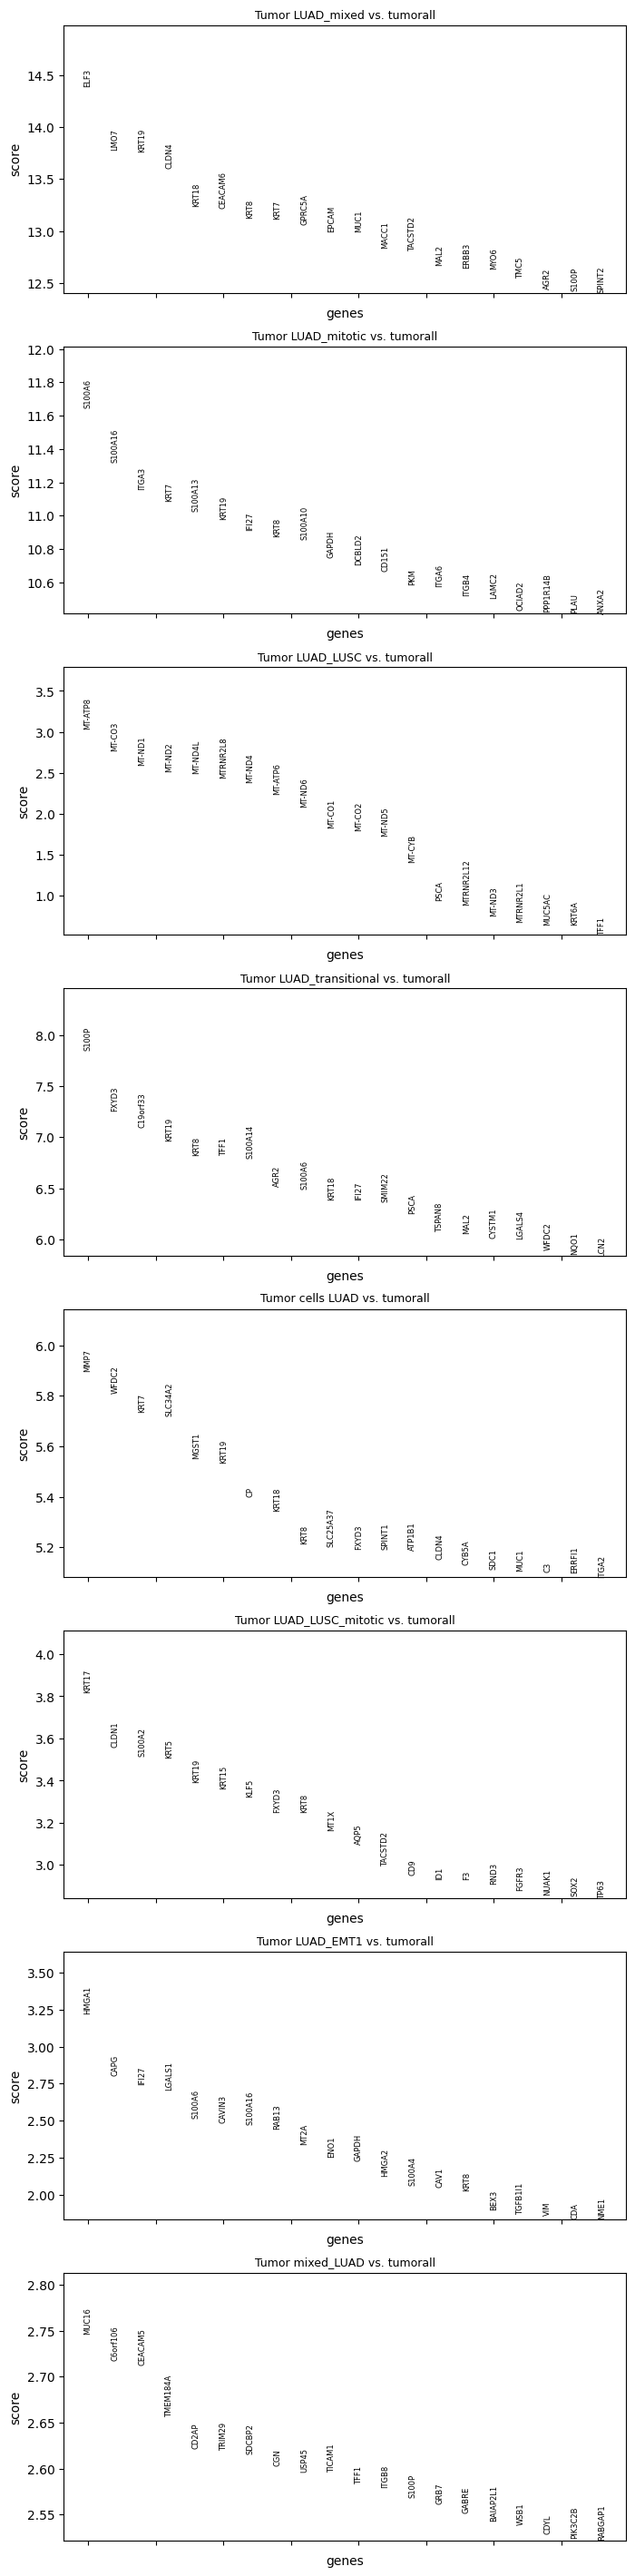

In [121]:
region = 'tumorall'
types = adata.uns[f'rank_genes_groups_{region}']['scores'].dtype.names
num_types = len(types)
fig, axs = plt.subplots(num_types, 1, figsize=(8, 4.5*(num_types)))
n_genes = 20
for i, type in enumerate(types):
    titlesize = 9
    fontsize = 6

    
    cond_plot(adata, [type], valid_types, n_genes=n_genes,
                     ax= axs[i], sharey=False, key=f'rank_genes_groups_{region}', show=False,
                     fontsize=fontsize, titlesize=titlesize)
    # cond_plot(adata, [type], valid_types, n_genes=n_genes,
    #                  ax= axs[i, 1], sharey=False, key=f'rank_genes_groups_onlytumor', show=False,
    #                  fontsize=fontsize, titlesize=titlesize)
    # cond_plot(adata, [tumor_tumor, normal_tumor], valid_types, n_genes=n_genes, ax= axs[i, 1],
    #                         key=f"w_pair_{type}_differ", show=False,
    #                  fontsize=fontsize, titlesize=titlesize)

# Display the entire figure with all plots
plt.show()

## Heatmaps

To show heatmap we need the logfold changes also...

In [ ]:
sc.tl.rank_genes_groups(

In [127]:
sc.pl.rank_genes_groups_heatmap(adata, show_gene_labels=True, key=f'wilcoxon')

KeyError: 'wilcoxon'

## GSEA

In [18]:
from gprofiler import GProfiler
import gseapy
import seaborn as sns
gp = GProfiler(return_dataframe=True, user_agent='INMEGEN')

In [39]:
# gen_list = adata.uns['wilcoxon']['names']['Airway epithelium_TT_Tumor'][100:]
# enrich = gp.profile(list(gen_list), sources=['GO:BP'], organism="hsapiens")
# enrich.iloc[:25,:]

In [19]:
#  Download Gene symbols
if not os.path.exists('h.all.v2023.2.Hs.symbols.gmt'):
    ! wget https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.2.Hs/h.all.v2023.2.Hs.symbols.gmt

#  Gene entrez
# if not os.path.exists('h.all.v2023.2.Hs.entrez.gmt'):
# ! wget https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.2.Hs/h.all.v2023.2.Hs.entrez.gmt

In [20]:
from typing import List

def get_gseas_df(adata: ad.AnnData, valid_types: List[str],
                 types: List[str], id_: str, load_gsea: bool = False,
                 key:str = 'rank_gene_groups', gsea_folder:str = 'gseapy_gsea') -> pd.DataFrame:
    """
    Generates a combined DataFrame from GSEA results for different cell types.

    Args:
    adata (ad.AnnData): An AnnData object containing the dataset.
    valid_types (List[str]): A list of valid cell types to filter the cell types.
    types (List[str]): A list of cell types to be considered for analysis.
    id_ (str): Identifier used in generating the GSEA path.
    load_gsea (bool, optional): Flag to load existing GSEA results. Defaults to False.

    Returns:
    pd.DataFrame: A combined DataFrame with GSEA results pivoted by cell type and hallmark.

    The function uses the provided 'types', intersects them with 'valid_types',
    and computes GSEA for each type. The final DataFrame is a pivot table with cell types as rows
    and GSEA hallmarks as columns.
    """
    # Intersect types with valid types
    types = set(types).intersection(valid_types)
    dfs = []

    for type in types:
        ranks = adata.uns[key]
        type_path = type.replace('/','_')
        gsea_path = f'{gsea_folder}/{type_path}_{id_}.npz'

        # Generate gene scores
        gene_scores = {gene: ranks['scores'][type][i] for i, gene in enumerate(ranks['names'][type])}
        gene_scores = pd.Series(gene_scores)

        # Run GSEA
        if load_gsea:
            gseas = np.load(gsea_path, allow_pickle='TRUE').item()
        else:
            pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
                                     processes=20, permutation_num=100, seed=6, no_plot=True)
            gseas = pre_res.res2d
            np.save(gsea_path, gseas)

        data1 = {'hallmark': list(gseas['Term'].str.slice(9)), 'score': list(gseas['NES'])}
        df_celltype1 = pd.DataFrame(data1)
        df_celltype1['cell_type'] = type
        dfs.append(df_celltype1)

    # Combine all DataFrames
    combined_df = pd.concat(dfs).reset_index(drop=True).pivot(index='cell_type', columns='hallmark', values='score')
    return combined_df

In [ ]:
%%time
#papermill_description=GSEA
gsea_folder = 'gseapy_gsea'
combined_dfs = {}

for region in regions:
    gsea_path = f'{gsea_folder}/heatmap_{region}_{time}.csv'
    if load_gsea_heatmap:
        combined_dfs[region] = pd.read_csv(gsea_path, index_col=0)
    else:
        types = adata.uns[f'rank_genes_groups_{region}']['scores'].dtype.names
        combined_dfs[region] = get_gseas_df(adata, valid_types, types, id_, load_gsea=False, key=f'rank_genes_groups_{region}')
        combined_dfs[region].to_csv(gsea_path)

/tmp/ipykernel_197393/3327198433.py:40: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-10-15 02:10:58,709 [WARNING] Duplicated values found in preranked stats: 29.32% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
/tmp/ipykernel_197393/3327198433.py:40: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-10-15 02:10:59,835 [WARNING] Duplicated values found in preranked stats: 29.32% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
/tmp/ipykernel_197393/3327198433.py:40: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-10-15 02:11:00,796 [WARNING] Duplicated values found in preranked stats: 29.34% of genes
The o

CPU times: user 24.1 s, sys: 2.22 s, total: 26.3 s
Wall time: 7.45 s


In [133]:
region

'tumorall'

In [134]:
combined_dfs[region]

hallmark,ADIPOGENESIS,ALLOGRAFT_REJECTION,ANDROGEN_RESPONSE,ANGIOGENESIS,APICAL_JUNCTION,APICAL_SURFACE,APOPTOSIS,BILE_ACID_METABOLISM,CHOLESTEROL_HOMEOSTASIS,COAGULATION,...,PROTEIN_SECRETION,REACTIVE_OXYGEN_SPECIES_PATHWAY,SPERMATOGENESIS,TGF_BETA_SIGNALING,TNFA_SIGNALING_VIA_NFKB,UNFOLDED_PROTEIN_RESPONSE,UV_RESPONSE_DN,UV_RESPONSE_UP,WNT_BETA_CATENIN_SIGNALING,XENOBIOTIC_METABOLISM
cell_type,,,,,,,,,,,,,,,,,,,,,
Tumor LUAD_EMT1,-1.110309,-1.187966,-1.076399,-0.766767,-0.959769,-0.974517,-1.199404,-0.962805,-0.867173,-0.839418,...,-1.164443,-0.848709,-0.992820,-1.184847,-1.376932,-1.168831,-1.155508,-1.293691,-1.133438,-0.940766
Tumor LUAD_LUSC,-1.118692,-1.114270,-1.150062,-0.997129,-1.040328,-0.965549,-1.175821,-0.968362,-1.075819,-1.067349,...,-1.198175,-1.163777,-0.983350,-1.191010,-1.212701,-1.190918,-1.084825,-1.171564,-0.987289,-1.064281
Tumor LUAD_LUSC_mitotic,-1.181496,-1.907773,-0.961349,-0.791275,-0.909830,-0.812643,-1.074107,-1.005675,0.988714,-0.989581,...,-1.281866,-0.986457,-0.918439,1.037783,-1.047122,-1.170017,-0.886268,-0.867881,1.219978,-0.896077
Tumor LUAD_mitotic,1.110441,0.751855,1.108778,1.060856,1.099499,1.008239,1.051733,1.008371,1.052844,1.032179,...,1.209107,1.123460,0.949745,1.115697,0.917457,1.140206,1.089084,1.001729,0.960654,1.047052
Tumor LUAD_mixed,1.112286,0.627898,1.133430,1.008180,1.057946,1.061560,1.065794,0.996010,1.124173,1.042324,...,1.213118,1.114333,0.987262,1.156688,0.979331,1.135866,1.070564,1.079657,0.995769,1.099947
Tumor LUAD_transitional,1.142484,-1.000000,1.184090,0.947639,1.059006,1.074997,1.047723,1.051705,1.194088,1.030733,...,1.253795,1.168413,1.054477,1.130919,0.717845,1.130334,1.024928,1.046472,0.879416,1.137557
Tumor cells LUAD,1.149852,0.779475,1.154392,1.103208,1.045939,0.934430,1.107962,1.035831,1.136464,1.156935,...,1.195951,1.077469,0.988131,1.253188,1.114717,1.168376,1.133003,1.121257,1.082056,1.097392
Tumor mixed_LUAD,0.823937,0.852631,1.122416,1.139809,1.226694,1.194823,1.336938,0.946565,1.003616,1.138924,...,1.150328,0.841188,-0.937906,1.235296,1.202435,0.933157,1.240699,1.021452,1.068886,0.902994


In [26]:
luad_emt1 = np.load(f'gseapy_gsea/Tumor LUAD_EMT1_Trinks_Bishoff_2021_NSCLC.npz.npy',allow_pickle=True)
luad_mitotic = np.load(f'gseapy_gsea/Tumor LUAD_mitotic_Trinks_Bishoff_2021_NSCLC.npz.npy',allow_pickle=True)

                 |  term: gene set name,
                 |  es: enrichment score,
                 |  nes: normalized enrichment score,
                 |  pval:  Nominal p-value (from the null distribution of the gene set,
                 |  fdr: FDR qvalue (adjusted False Discory Rate),
                 |  fwerp: Family wise error rate p-values,
                 |  tag %: Percent of gene set before running enrichment peak (ES),
                 |  gene %: Percent of gene list before running enrichment peak (ES),
                 |  lead_genes: leading edge genes (gene hits before running enrichment peak),
                 |  matched genes: genes matched to the data,

In [25]:
luad_emt1

array([['prerank', 'HALLMARK_TNFA_SIGNALING_VIA_NFKB',
        -0.7470017338632792, -1.3769315294607698, 0.0,
        0.01004823151125402, 0.01, '116/198', '11.12%',
        'DUSP1;KLF6;BTG2;IRF1;IER5;JUNB;ZFP36;SAT1;JUN;PPP1R15A;NFKBIA;GADD45B;REL;BTG1;KLF2;LITAF;MCL1;CCNL1;FOSB;PNRC1;CFLAR;FOS;TNFAIP3;ATF3;SOCS3;IL6ST;KDM6B;ID2;SOD2;NFE2L2;RHOB;DUSP2;NR4A2;FOSL2;CEBPD;ATP2B1;TNFAIP8;BIRC3;KLF4;SGK1;CD69;TIPARP;NFKB1;IER2;NR4A1;TANK;SQSTM1;CCL4;NAMPT;SLC2A3;ICAM1;NINJ1;MAP2K3;B4GALT1;CCL5;HES1;MAP3K8;PLK2;NR4A3;DUSP5;TAP1;PFKFB3;NFAT5;TNFAIP2;ABCA1;BTG3;PDE4B;CDKN1A;EHD1;MAFF;TRIB1;BCL3;MXD1;PLEK;DNAJB4;ZBTB10;PTPRE;BCL6;CD83;TNIP2;GEM;IL7R;KLF9;GPR183;GADD45A;EGR1;CXCL2;G0S2;IER3;PER1;HBEGF;BIRC2;F3;ETS2;NFKBIE;JAG1;TNF;CSF1;NFKB2;RIPK2;SMAD3;TNIP1;RNF19B;IFIH1;EFNA1;MYC;DENND5A;CXCL3;PDLIM5;EGR2;ZC3H12A;IL1B;GCH1;IFNGR2;SDC4;PLPP3'],
       ['prerank', 'HALLMARK_INTERFERON_GAMMA_RESPONSE',
        -0.6981915127544074, -1.3200368082766636, 0.0,
        0.06028938906752412, 0.12, '126

In [27]:
luad_mitotic

array([['prerank', 'HALLMARK_MYC_TARGETS_V1', 0.8066915036127081,
        1.250284598574121, 0.0, 0.01, 0.01, '161/195', '11.96%',
        'LDHA;PGK1;PPIA;CANX;SNRPD1;PRDX4;YWHAQ;PSMB2;NME1;PSMB3;PSMA1;HDGF;VDAC1;KPNB1;SYNCRIP;RPL18;EIF4G2;PSMA7;AP3S1;CBX3;SET;RACK1;EIF4H;RANBP1;ERH;SSBP1;XRCC6;EIF2S2;UBE2L3;HDAC2;YWHAE;PSMA4;NPM1;SNRPD2;PSMD8;PSMD3;CNBP;RPL22;NDUFAB1;EIF3B;CCT2;POLD2;PHB2;SRPK1;PSMD7;SNRPB2;EIF3D;PSMC6;CCT7;HNRNPA3;PPM1G;CCT5;HNRNPD;DUT;ACP1;COX5A;PSMC4;RPLP0;EIF1AX;PTGES3;APEX1;SNRPG;CCT3;SNRPD3;LSM7;PSMD14;PA2G4;RPL14;PSMA2;HNRNPC;PRDX3;RAD23B;SERBP1;BUB3;PSMD1;NHP2;RPS2;SSB;EIF3J;RPS6;HNRNPR;SRM;EIF4A1;HSP90AB1;RNPS1;RAN;XPOT;ILF2;RPS3;XPO1;RPL34;SLC25A3;RPS5;PCBP1;SRSF2;CYC1;TRIM28;NCBP2;TUFM;FAM120A;HNRNPA2B1;PABPC1;DHX15;CDK4;CCT4;G3BP1;PRPF31;EIF2S1;RSL1D1;GSPT1;PABPC4;HDDC2;RPS10;SRSF1;TARDBP;EEF1B2;EXOSC7;DDX21;SMARCC1;TCP1;GLO1;LSM2;UBA2;HNRNPA1;HNRNPU;GNL3;RUVBL2;MRPL23;ABCE1;CLNS1A;COPS5;DDX18;VDAC3;NAP1L1;MRPS18B;DEK;EIF4E;VBP1;HPRT1;POLE3;SNRPA1;GOT2;PCN

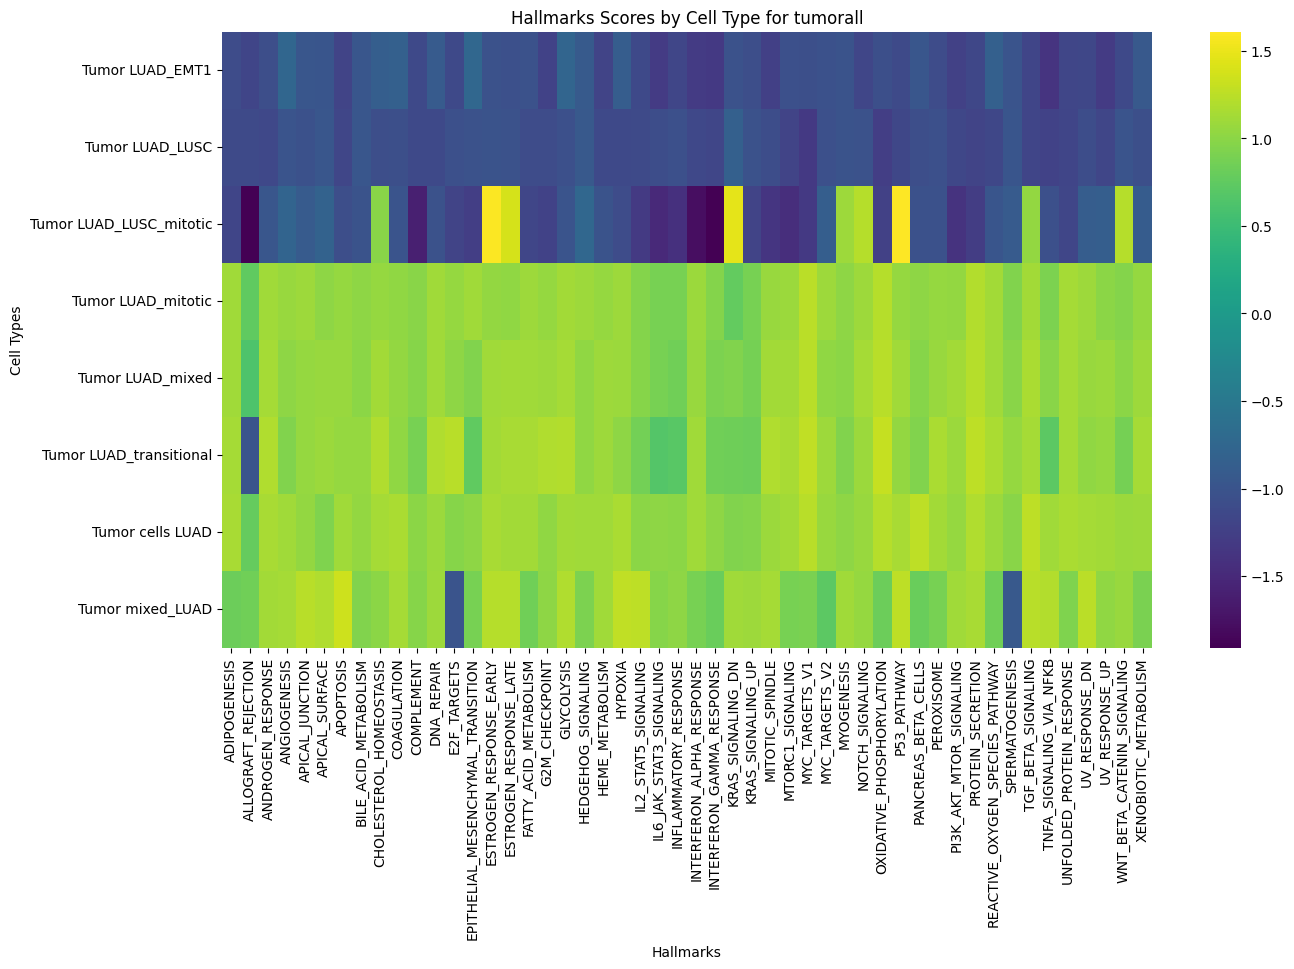

In [135]:
# Plotting the heatmap
# combined_df_tumor = combined_df.loc[combined_df.index.str.split('_').str[-1] == 'Tumor']
for region in regions:
    plt.figure(figsize=(15, 8))
    sns.heatmap(combined_dfs[region], cmap='viridis')
    plt.title(f'Hallmarks Scores by Cell Type for {region}')
    plt.xlabel('Hallmarks')
    plt.ylabel('Cell Types')
    plt.show()

Luad_EMT1 and LUAD_LUSC Have less tha n10 cells each. So maybe they are not representative.
But, mixed_Luad also has almost no cells. So what gives?

Tumor LUAD_mixed                   1146
Tumor LUAD_mitotic                  284
Tumor LUAD_LUSC                     233
Tumor LUAD_transitional              46
Tumor cells LUAD                     25
Tumor LUAD_EMT1                       7
Tumor mixed_LUAD                      3

Lets try with Deng

The clustering does not divide the cells in Bishoff ver finely.
Apparently it groups all kindos of cells into a big cluster... and the small clusters are not very representative.